
### SYSTEMATIC TAA - Monetary - US - Yield Curve Model
- Model: Monetary signal combined with price momentum signal
- Trading frequency: monthly
- Universe & Time Period:
    - S&P500 index: 1960 - Nov 2022
    - US Yields: 1960 - Nov 2022
- Simple rules:
    - If the % of US inverted yield curces is below 20%: Risk-on mode: no recession risk, invest in the S&P500.
    - If the percentage of inverted yield curves exceeds 20 %: Risk-off mode: recession risk is high, use a cross-asset momentum
     	filter to invest in the two asset classes with the highest composite trend score.
    		- Asset classes considered in risk-off modus: Tbills, Treasuries, 
   
- Technical:
    - % of yield curves:calculate all curves across 3m,6m,1y,2y,5y,10y,20y and 30y 
    - Composite trend score: Weighted average return over the past 1m,3m,6m and 12m with weights: 40%, 30%, 20%, 10%
- **_Remarks_**:
    -- Trading costs: 20 bps 
    - Dividends are not taken into account!
    - Any mistakes remain mine. If you find any, please do let me know so I can rectify. Thank you!


In [1]:
!pip install empiricaldist
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12107 sha256=095f2c71b31ea232608834080ce736fa596825663af72e7fd815ea306bd4cf15
  Stored in directory: /home/repl/.cache/pip/wheels/c2/3f/cf/74b5adbcea4efaae43ce168e622e3eb8dbc1251d5d730dd245
Successfully built empiricaldist
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import scipy.stats as ss
#import empiricaldist as emp
import seaborn as sns
from fredapi import Fred


In [3]:
#FUNCTIONS USED IN NOTEBOOK

def get_fred_yield(per):
    """Get the historical yield for a tenor from Fred database on a monhtly basis. 
    Rename the series.
    Args:
        per(int): Term.Tenor. Year.
    """
    yld=fred.get_series(f'DGS{per}').resample('M').last()
    yld.index.rename('date',inplace=True)
    yld.name=f'yield_{per}y'
    return yld       





def duration(c, y, m, n):
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y) )
    modified_duration = macaulay_duration / (1 + y)
    return macaulay_duration


def mom_score(r):
    """"Calculates a composite momentum score for a return series over 12,3,6 and 1 month with weights"
    Args:
        r(pd.Series): the Return series in R format
    Returns:
        pd.Series:composite momentum score
     """
    ret1M=r
    ret3M=(r+1).rolling(3).apply(np.prod)-1
    ret6M=(r+1).rolling(6).apply(np.prod)-1
    ret12M=(r+1).rolling(12).apply(np.prod)-1
    mom=0.4*ret1M+0.3*ret3M+0.2*ret6M+0.1*ret12M
    return mom

def annualized_return(r,per):
    """ Annualized return calculated from a pd.Series or DataFrame.r may contain null values at start series.
    Args:
        r(pd.Series or Dataframe):return per period in R-format (eg:0.005=0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized return
    """
    yearfraq=(r.shape[0]-r.isna().sum())/per
    wealth=(1+r).prod()
    annual_return=(wealth)**(1/yearfraq)-1
    return annual_return   

def annualized_vol(r,per):
    """ Annualized volatility calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    annual_vol=r.std()*np.sqrt(per)
    return annual_vol

def downside_vol(r,per):
    """ Annualized volatility of the negative returns calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    down_vol=r[r<0].std()*np.sqrt(per)
    return down_vol

def sharpe_ratio(r1,r2,per):
    """ Sharpe ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_volatility=annualized_vol(r1,per)
    sharpe=(strategy_return-risk_free_return)/strategy_volatility
    
    return sharpe

def sortino_ratio(r1,r2,per):
    """ Sortino ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_downside_volatility=downside_vol(r1,per)
    sortino=(strategy_return-risk_free_return)/strategy_downside_volatility
    
    return sortino

  


def tracking_error(r1,r2,per):
    """ Annualized tracking error calculated from 2 return series.
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized tracking error
    """
    excess_ret=r1-r2
    track_error=excess_ret.std()*np.sqrt(12)
    return track_error

def information_ratio(r1,r2,per):
    """ Calculates the information ratio of a strategy based on return series strategy, return series benchmark 
    and period adjustment factor to annualized volatlity.
    ir= (annual return strategy - annual return bench)/tracking error
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: information ratio
    """
    annual_return_strategy=annualized_return(r1,per)
    annual_return_benchmark=annualized_return(r2,per)
    track_error=tracking_error(r1,r2,per)
    ir = (annual_return_strategy-annual_return_benchmark)/track_error
    return ir


def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns kurtosis as a float or a Series. Scipy function returns excess kurtosis above 3.
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4






from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))





#function to style a dataframe that shows returns in pivot form
def style_df(df_):
    def style_negative(v, props=''):
        return props if v < 0 else None
    
    cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#7FB3D5")]
    }
    index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: white"
    }
    headers = {
    "selector": "th",
    "props": "background-color: #273746; color: white"
    }
    cells = {
    "selector": "td",
    "props": "background-color: white; font-size: 13px;font-family: sans-serif;border-collapse:collapse; border: 1px solid"
    }  
    x=df_.style\
        .applymap(style_negative, props='color:red;')\
        .format(formatter='{:,.2f}%',na_rep='-')\
        .set_table_styles([cell_hover,index_names, headers,cells])
    return x          

[*********************100%***********************]  1 of 1 completed


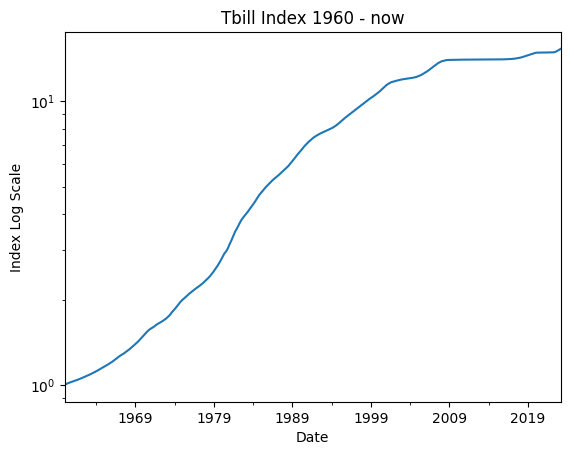

Date
1960-01-31    0.003460
1960-02-29    0.002993
1960-03-31    0.003030
1960-04-30    0.002563
1960-05-31    0.002744
Freq: M, Name: tbill_tr, dtype: float64

In [4]:
#Import Tbill data and calculate monthly returns
start='1950-01-31'
tbill_d=yf.download("^IRX",start)['Adj Close']
tbill_dr=tbill_d/100/252+1
tbill_series=tbill_dr.resample('M').prod()-1
tbill_series.name='tbill_tr'
tbill_series.index=tbill_series.index.tz_localize(None)

#Tbill Chart
(tbill_series+1).cumprod().plot(logy=True)
plt.title('Tbill Index 1960 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
tbill_series.head()

[*********************100%***********************]  1 of 1 completed


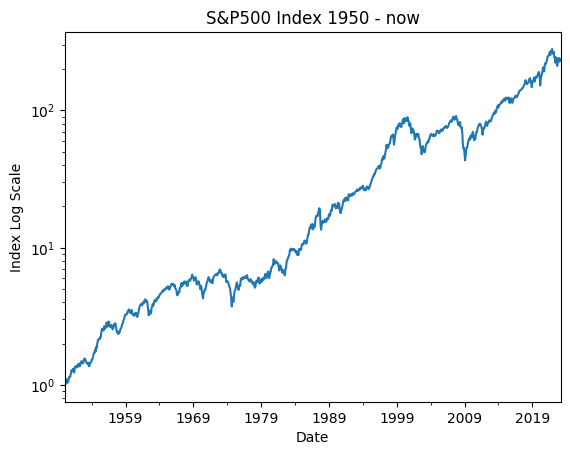

Date
1950-01-31    0.000000
1950-02-28    0.009971
1950-03-31    0.004065
1950-04-30    0.038751
1950-05-31    0.045657
Freq: M, Name: sp500_tr, dtype: float64

In [5]:
#Download S&P500 price data from Yahoo Finance
sp500_series=yf.download("^GSPC","1950-01-31")['Adj Close'].pct_change()+1
sp500_series=sp500_series.resample('M').prod()-1
sp500_series.name='sp500_tr'
sp500_series.index=sp500_series.index.tz_localize(None)

#S&P500 Chart
(sp500_series+1).cumprod().plot(logy=True)
plt.title('S&P500 Index 1950 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
sp500_series.head()

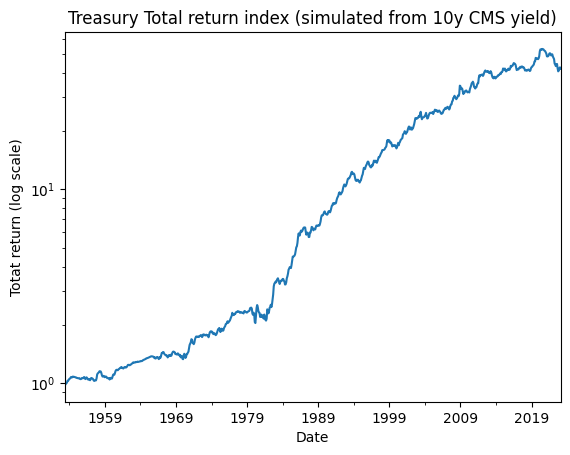

,treasury_yield,yield_chg,dur,treasury_tr
Date,,,,
2022-10-31,0.0398,0.0046,8.442113,-0.035517
2022-11-30,0.0389,-0.0009,8.472742,0.010867
2022-12-31,0.0362,-0.0027,8.565778,0.026144
2023-01-31,0.0353,-0.0009,8.597177,0.010679
2023-02-28,0.0375,0.0022,8.520767,-0.015621


In [6]:
#Download Treasury Yield data from NasdaqLink to construct a Treasury Index
url_ty='https://data.nasdaq.com/api/v3/datasets/FED/RIFLGFCY10_N_M.csv?api_key=5VHLVjsL1zzxZ77rMAD4'
custom_date_parser=lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
treasury=pd.read_csv(url_ty,index_col='Date',parse_dates=True,date_parser=custom_date_parser)
treasury.sort_index(inplace=True)
treasury=treasury.resample('M').last()
treasury.columns=['treasury_yield']
treasury['treasury_yield']=treasury['treasury_yield']/100

#Calculate a monthly Treasury total return value using yield as coupon and duration function. Should add convexity!
treasury['yield_chg']=treasury['treasury_yield'].diff()
treasury['dur']=duration(treasury['treasury_yield'].values,treasury['treasury_yield'].values,1,10)
treasury['treasury_tr']=treasury['treasury_yield']/12-(treasury['yield_chg']*treasury['dur'])
treasury.dropna(inplace=True)

#Treasury Chart
(treasury['treasury_tr']+1).cumprod().plot(logy=True)
plt.title('Treasury Total return index (simulated from 10y CMS yield)')
plt.ylabel('Totat return (log scale)')
plt.show()
treasury.tail()

In [7]:
#CONSTRUCT THE US YIELD CURVE DIFFUSION INDEX

#Get the 3-month Tbill Yield series on a end-of-month basis
tbill_d.index=tbill_d.index.tz_localize(None)
yield_3m=tbill_d.resample('M').last()
yield_3m.name='yield_3m'

#Creat fred object to download
fred = Fred(api_key='48687714d90448d876bb115d06578128 ')

#download yield series, resample to end of month and rename index and series itself
yield_6m = fred.get_series('DTB6').resample('M').last()
yield_6m.index.rename('date',inplace=True)
yield_6m.name='yield_6m'
     
#download yields with function we created
yield_1y=get_fred_yield(1)
yield_2y=get_fred_yield(2)
yield_3y=get_fred_yield(3)
yield_5y=get_fred_yield(5)
yield_7y=get_fred_yield(7)
yield_10y=get_fred_yield(10)
yield_20y=get_fred_yield(20)
yield_30y=get_fred_yield(30)

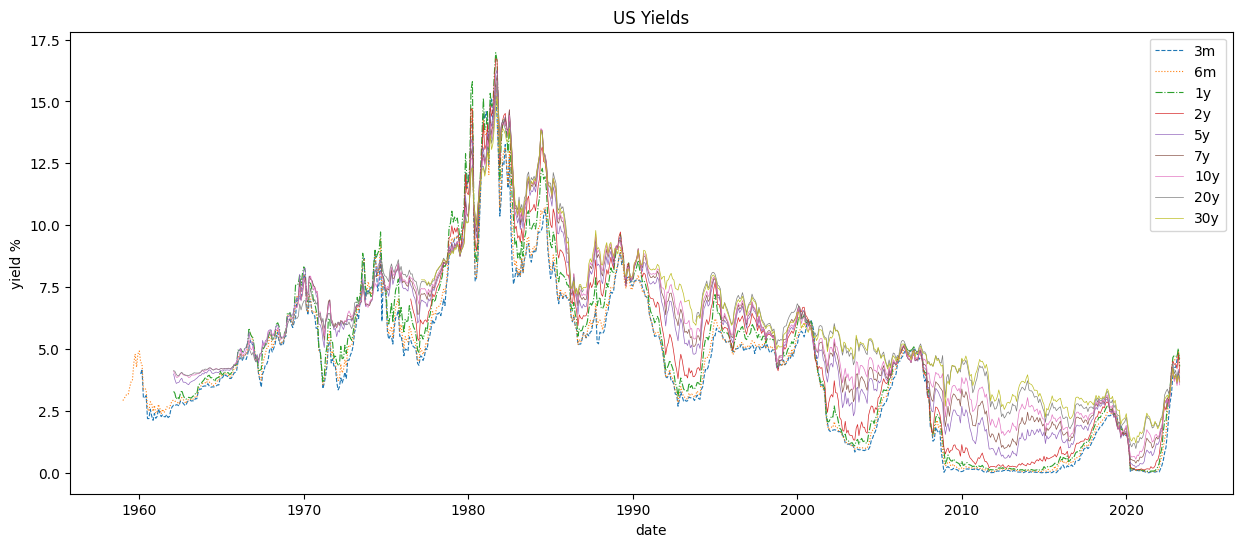

In [8]:
#Chart the yields
plt.figure(figsize=(15,6))
plt.plot(yield_3m,linestyle='--',linewidth=0.8,label='3m')
plt.plot(yield_6m,linestyle='dotted',linewidth=0.8,label='6m')
plt.plot(yield_1y,linestyle='dashdot',linewidth=0.8,label='1y')
plt.plot(yield_2y,linewidth=0.5,label='2y')
plt.plot(yield_5y,linewidth=0.5,label='5y')
plt.plot(yield_7y,linewidth=0.5,label='7y')
plt.plot(yield_10y,linewidth=0.5,label='10y')
plt.plot(yield_20y,linewidth=0.5,label='20y')
plt.plot(yield_30y,linewidth=0.5,label='30y')
plt.title('US Yields')
plt.xlabel('date')
plt.ylabel('yield %')
plt.legend()
plt.show()

In [9]:
yield_10y.index[0]

Timestamp('1962-01-31 00:00:00', freq='M')

In [10]:
#creat df of yield and calculate all yield curves
yields=pd.concat([yield_3m,yield_6m,yield_1y,yield_2y,yield_3y,yield_5y,yield_10y,yield_30y],axis=1)
yields.index.rename('date',inplace=True)

In [11]:
#calaculate all yield curves with a while loop
i=7
while i >=0:
    j=i-1
    while j>=0:
        yields[yields.columns[i]+' - '+yields.columns[j]] =yields[yields.columns[i]]-yields[yields.columns[j]]
        j=j-1
    i=i-1

#count number of yiel curves with Nan values in each row
yields['null_values']=yields.iloc[:,8:].isnull().sum(axis=1)
#count number of yields curves >0 in each row
mask=yields.iloc[:,8:-1]<0
yields['below_0']=yields[mask].count(axis=1)
#calculate the breath
yields['diffusion_index']=yields['below_0']/(28-yields['null_values'])
#create the series seperate without nulls and assign to value
diffusion_index=yields['diffusion_index']['1961-01':]

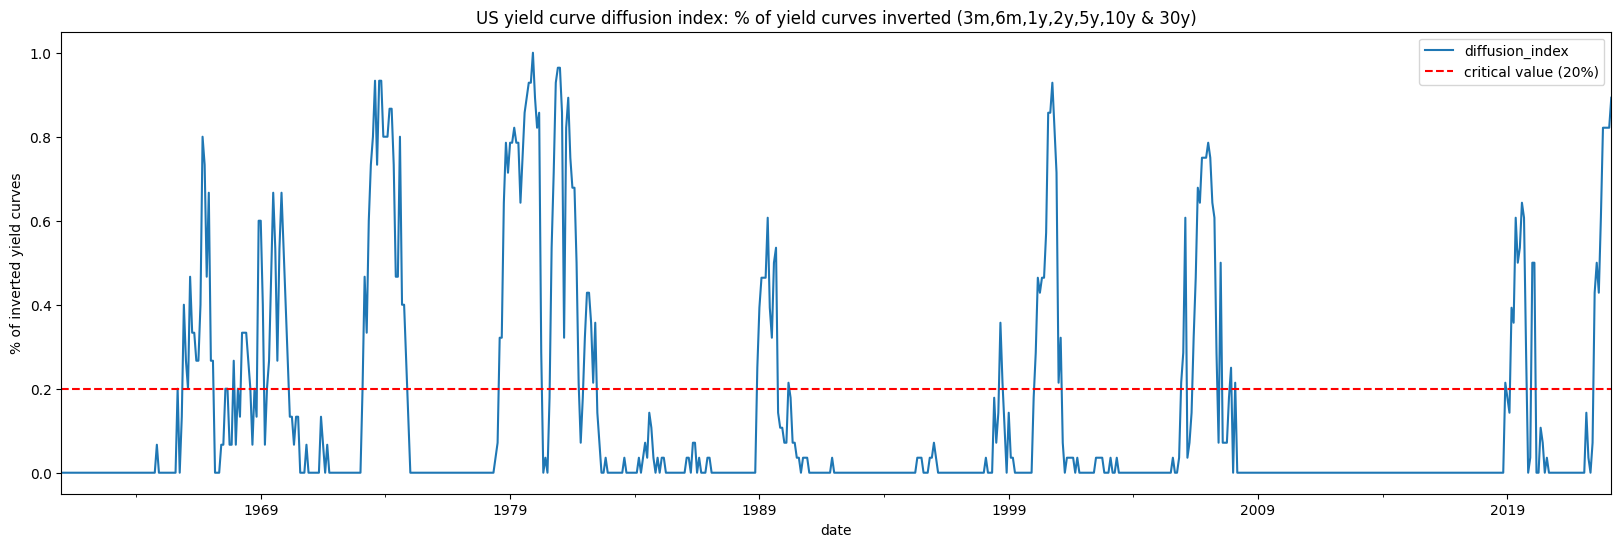

In [12]:
#chart the diffusion index
plt.figure(figsize=(20,6))
diffusion_index.plot()
plt.title('US yield curve diffusion index: % of yield curves inverted (3m,6m,1y,2y,5y,10y & 30y)')
plt.xlabel('date')
plt.ylabel('% of inverted yield curves')
critical_value=0.2
plt.axhline(critical_value,color='red',linestyle='--',label='critical value (20%)')
plt.legend()
plt.savefig('yield_curve.png')
plt.show()


In [13]:
#create the strategy df
strat_df=pd.concat([tbill_series,treasury['treasury_tr'],sp500_series,diffusion_index],axis=1)
#We only want to work as from 1961 as we have values for everything there
strat_df=strat_df['1961-01':]
strat_df.index.rename('date',inplace=True)


#Create '60/40 returns
strat_df['bench_tr']=0.6*strat_df['sp500_tr']+0.4*strat_df['treasury_tr']
strat_df

#Calculate momentum scores for SP500,Treasuries and Tbills
strat_df['sp500_mom']=mom_score(strat_df['sp500_tr'])
strat_df['treasury_mom']=mom_score(strat_df['treasury_tr'])
strat_df['tbill_mom']=mom_score(strat_df['tbill_tr'])
strat_df.dropna(inplace=True)
strat_df

strat_df.to_csv('spx_treasury_1961.csv')


In [14]:
#%%script false --no-raise-error

#Built the trading signal based on the diffusion index only

# create a list of our conditions
conditions=[
    (strat_df['diffusion_index'].shift(1) < 0.2),
    (strat_df['diffusion_index'].shift(1) > 0.2) & (strat_df['treasury_mom'].shift(1)>strat_df['tbill_mom'].shift(1)),
    (strat_df['diffusion_index'].shift(1)>0.2) & (strat_df['tbill_mom'].shift(1)>strat_df['treasury_mom'].shift(1)) 
]


# create a list of the values we want to assign for each condition
values = [strat_df['sp500_tr'],strat_df['treasury_tr'],strat_df['tbill_tr']]

#Calculate trading signals based on conditions list
trade_signal=[]
for k in range(strat_df.shape[0]):
    month=[conditions[0][k],conditions[1][k],conditions[2][k]]
    prev_month=[conditions[0][k-1],conditions[1][k-1],conditions[2][k-1]]
    if month==prev_month:
        trade_signal.append(0)
    else:
        trade_signal.append(1)
        
strat_df['trade_signal']=trade_signal
strat_df['trade_signal']=strat_df['trade_signal'].shift(-1)
 
# create a new column and use np.select to assign values to it using our lists as arguments
strat_df['strat_tr']=np.select(conditions,values)

#Calculate net returns taking into account transaction cost, based on trading signal
commission=0.002
strat_df['strat_nr']=np.where(strat_df['trade_signal'].shift(2)!=strat_df['trade_signal'].shift(1),strat_df['strat_tr']-commission,strat_df['strat_tr'])

In [15]:
#save the strat return series to CSV
strat_return_series=strat_df['strat_nr']
strat_return_series.index.rename('date',inplace=True)
strat_return_series.name='yield_curve_return'
strat_return_series.to_csv('yield_curve_return.csv')

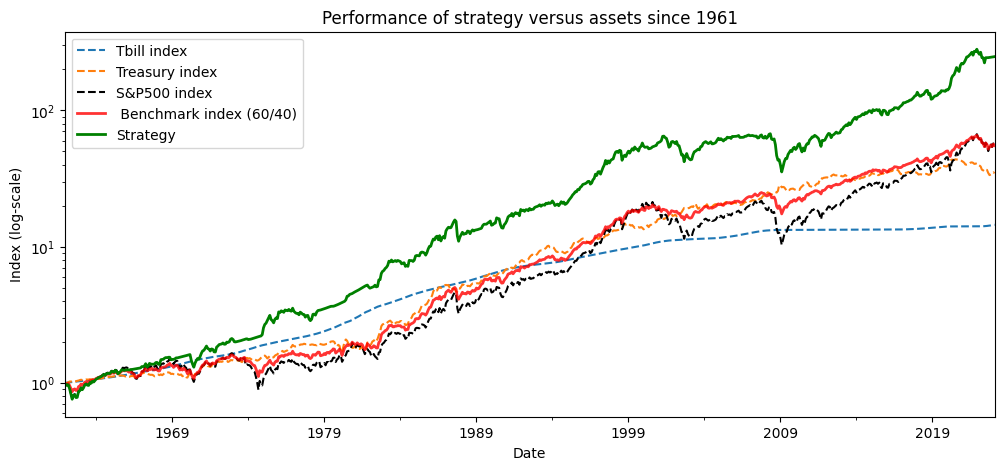

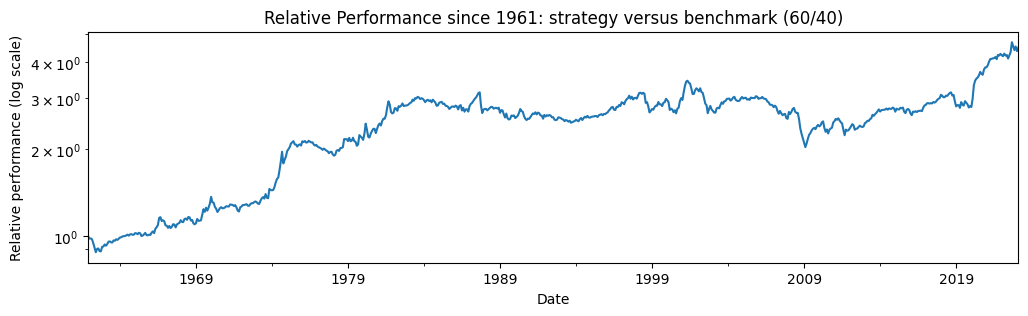

In [16]:
#Build wealth indices for comparison purposes
strat_df['tbill_index']=(strat_df['tbill_tr']+1).cumprod()
strat_df['treasury_index']=(strat_df['treasury_tr']+1).cumprod()
strat_df['sp500_index']=(strat_df['sp500_tr']+1).cumprod()
strat_df['bench_index']=(strat_df['bench_tr']+1).cumprod()
strat_df['strat_index']=(strat_df['strat_nr']+1).cumprod()

#plot the assets and strategy
strat_df['tbill_index'].plot(logy=True,label='Tbill index',figsize=(12,5),linestyle='--')
strat_df['treasury_index'].plot(logy=True,label='Treasury index',linestyle='--')
strat_df['sp500_index'].plot(logy=True,label='S&P500 index',linestyle='--',color='black')
strat_df['bench_index'].plot(logy=True, label=' Benchmark index (60/40)',linewidth=2,color='red',alpha=0.8)
strat_df['strat_index'].plot(logy=True, label='Strategy',linewidth=2,color='green')
plt.title('Performance of strategy versus assets since 1961')
plt.xlabel('Date')
plt.ylabel('Index (log-scale)')
plt.legend()
plt.savefig('strategy_vs_assets.png')
plt.show()


#relative performance
strat_df['relative']=strat_df['strat_index']/strat_df['bench_index']
strat_df['relative'].plot(logy=True,figsize=(12,3))
plt.title('Relative Performance since 1961: strategy versus benchmark (60/40)')
plt.xlabel('Date')
plt.ylabel('Relative performance (log scale)')
plt.savefig('relative performance.png')
plt.show()


In [17]:
strat_df.tail()

,tbill_tr,treasury_tr,sp500_tr,diffusion_index,bench_tr,sp500_mom,treasury_mom,tbill_mom,trade_signal,strat_tr,strat_nr,tbill_index,treasury_index,sp500_index,bench_index,strat_index,relative
date,,,,,,,,,,,,,,,,,
2022-10-31,0.003043,-0.035517,0.079863,0.607143,0.033711,-0.015324,-0.073522,0.007271,0.0,0.003043,0.003043,14.275027,33.499619,54.290241,53.730104,244.322038,4.547210
2022-11-30,0.003431,0.010867,0.053753,0.821429,0.036599,0.017811,-0.048011,0.008629,0.0,0.003431,0.003431,14.324009,33.863664,57.208499,55.696550,245.160382,4.401716
2022-12-31,0.003513,0.026144,-0.058971,0.821429,-0.024925,-0.018930,-0.009700,0.009769,0.0,0.003513,0.003513,14.374331,34.749005,53.834829,54.308303,246.021671,4.530093
2023-01-31,0.003583,0.010679,0.061753,0.821429,0.041323,0.028234,-0.000834,0.010693,0.0,0.003583,0.003583,14.425840,35.120094,57.159284,56.552505,246.903252,4.365912
2023-02-28,0.003495,-0.015621,-0.026112,0.821429,-0.021916,-0.026996,-0.023202,0.011243,NaN,0.003495,0.003495,14.476260,34.571494,55.666712,55.313113,247.766223,4.479340


In [18]:
var_monthly=var_gaussian(strat_df.strat_nr,0.01)
var_monthly

0.13050785088540381

In [19]:
#PERFORMANCE METRICS STRATEGY AND BENCHMARK

#correlation between strategy and bench
cor=strat_df["strat_nr"].corr(strat_df['bench_tr'])

#calculate turnover
turnover=strat_df['trade_signal'].mean()

#Annualized Returns
risk_free_ar=annualized_return(strat_df['tbill_tr'],12)
sp500_ar=annualized_return(strat_df['sp500_tr'],12)
treasury_ar=annualized_return(strat_df['treasury_tr'],12)
bench_ar=annualized_return(strat_df['bench_tr'],12)
strat_ar=annualized_return(strat_df['strat_nr'],12)

#Best and worst period returns
strat_best=strat_df['strat_nr'].max()
strat_worst=strat_df['strat_nr'].min()
bench_best=strat_df['bench_tr'].max()
bench_worst=strat_df['bench_tr'].min()
#% profitable
strat_prof=(strat_df['strat_nr']>0).mean()
bench_prof=(strat_df['bench_tr']>0).mean()

#AnnualizedVol
strat_vol=annualized_vol(strat_df['strat_nr'],12)
bench_vol=annualized_vol(strat_df['bench_tr'],12)

#Annualized downside vol
strat_down_vol=downside_vol(strat_df['strat_nr'],12)
bench_down_vol=downside_vol(strat_df['bench_tr'],12)

#Sharpe
strat_sharpe=sharpe_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sharpe=sharpe_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Sortino
strat_sortino=sortino_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sortino=sortino_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Tracking error
strat_tracking_error=tracking_error(strat_df['strat_nr'],strat_df['bench_tr'],12)

#InformationRatio
strat_info_ratio=information_ratio(strat_df['strat_nr'],strat_df['bench_tr'],12)
#information_ratio=(strat_ar-bench_ar)/strat_tracking_error 

#skew of strategy and benchmark
strat_skew=skewness(strat_df.strat_nr)
bench_skew=skewness(strat_df.bench_tr)

#Excess kurtosis of strategy and benchmark
strat_kurt=kurtosis(strat_df.strat_nr)
bench_kurt=kurtosis(strat_df.bench_tr)

#Var of strategy and benchmark

strat_var99=np.quantile(strat_df['strat_nr'],q=0.01)
bench_var99=np.quantile(strat_df['bench_tr'],q=0.01)

#CVAR of strategy and benchmark
strat_cvar99=strat_df['strat_nr'][strat_df['strat_nr']<strat_var99].mean()
bench_cvar99=strat_df['bench_tr'][strat_df['bench_tr']<bench_var99].mean()

#Parametric Gaussian VAR monhtly
strat_pvar99=var_gaussian(strat_df['strat_nr'],0.01)*-1
bench_pvar99=var_gaussian(strat_df['bench_tr'],0.01)*-1

#Cornish-Fisher monhtly var at 1%
strat_cf_var99=var_gaussian(strat_df['strat_nr'],level=0.01,modified=True)*-1
bench_cf_var99=var_gaussian(strat_df['bench_tr'],level=0.01,modified=True)*-1

#Drawdowns Strategy
strat_max=strat_df['strat_index'].cummax()
strat_dd=strat_df['strat_index']/strat_max-1
#Drawdowns Bench
bench_max=strat_df['bench_index'].cummax()
bench_dd=strat_df['bench_index']/bench_max-1
#MaxDrawdown
strat_md=min(strat_dd)
bench_md=min(bench_dd)
#MAR since inception
strat_r_to_md=strat_ar/abs(strat_md)
bench_r_to_md=bench_ar/abs(bench_md)

In [20]:
#Put Everything in DataFrame
output_dict={'Performance Metrics':['Correlation with benchmark','CAGR%','Best month','Worst month','% profitable','Vol','Downside Vol','Sharpe Ratio','Sortino Ratio','Information Ratio','Tracking Error','Skewness','Kurtosis','Historic monthly var (1%)','Historic monthly Cvar (1%)','Gaussian monthly var (1%)','Cornish-Fisher monthly var (1%)','Max Drawdown %','MAR ratio','Average Turnover per Year'],
        'Strategy':['{:.2f}%'.format(cor*100),'{:.2f}%'.format(strat_ar*100),'{:.2f}%'.format(strat_best*100),'{:.2f}%'.format(strat_worst*100),'{:.2f}%'.format(strat_prof*100),'{:.2f}%'.format(strat_vol*100),'{:.2f}%'.format(strat_down_vol*100),'{:.2f}'.format(strat_sharpe),'{:.2f}'.format(strat_sortino),'{:.2f}'.format(strat_info_ratio),'{:.2f}%'.format(strat_tracking_error*100),'{:.2f}'.format(strat_skew),'{:.2f}'.format(strat_kurt),'{:.2f}%'.format(strat_var99*100),'{:.2f}%'.format(strat_cvar99*100),'{:.2f}%'.format(strat_pvar99*100),'{:.2f}%'.format(strat_cf_var99*100),'{:.2f}%'.format(strat_md*100),'{:.2f}'.format(strat_r_to_md),'{:.2f}%'.format(turnover*100*12)],
        'Benchmark 60/40':['-','{:.2f}%'.format(bench_ar*100),'{:.2f}%'.format(bench_best*100),'{:.2f}%'.format(bench_worst*100),'{:.2f}%'.format(bench_prof*100),'{:.2f}%'.format(bench_vol*100),'{:.2f}%'.format(bench_down_vol*100),'{:.2f}'.format(bench_sharpe),'{:.2f}'.format(bench_sortino),'-','-','{:.2f}'.format(bench_skew),'{:.2f}'.format(bench_kurt),'{:.2f}%'.format(bench_var99*100),'{:.2f}%'.format(bench_cvar99*100),'{:.2f}%'.format(bench_pvar99*100),'{:.2f}%'.format(bench_cf_var99*100),'{:.2f}%'.format(bench_md*100),'{:.2f}'.format(bench_r_to_md),'{:.2f}%'.format(0)]}

start=strat_df.index[0].strftime("%Y-%m")
end = strat_df.index[-1].strftime("%Y-%m")

metrics=pd.DataFrame(output_dict)
metrics=metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
metrics


,Performance Metrics ( 1961-12 till 2023-02),Strategy,Benchmark 60/40
0,Correlation with benchmark,81.24%,-
1,CAGR%,9.42%,6.77%
2,Best month,13.18%,10.74%
3,Worst month,-21.76%,-13.02%
4,% profitable,68.30%,60.95%
5,Vol,12.93%,9.80%
6,Downside Vol,10.48%,6.60%
7,Sharpe Ratio,0.38,0.24
8,Sortino Ratio,0.47,0.35
9,Information Ratio,0.35,-


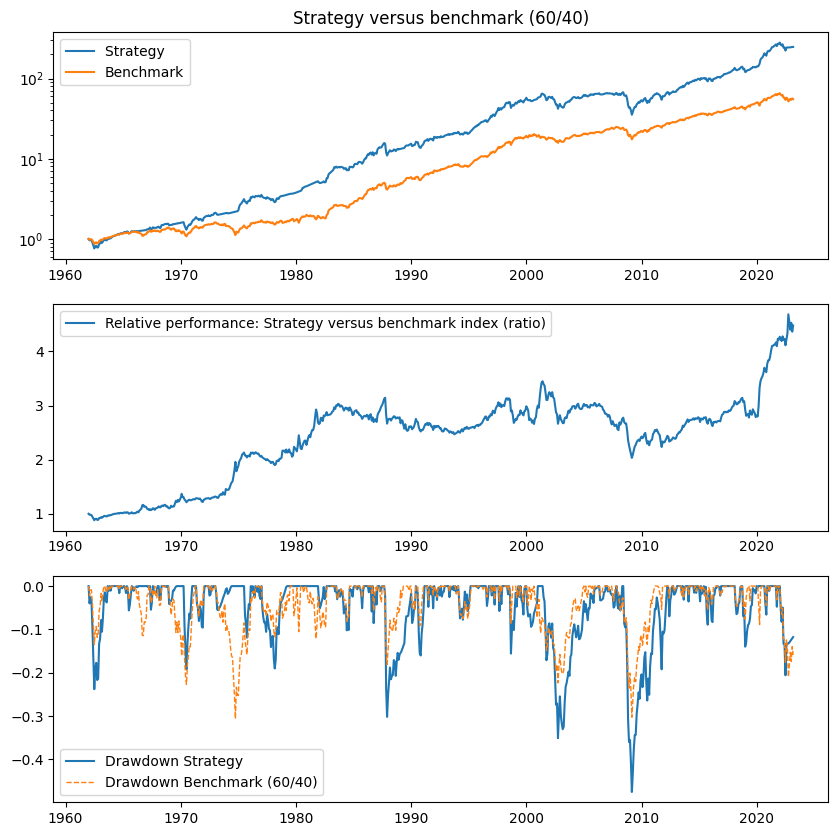

In [21]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Strategy versus benchmark (60/40)")
ax[0].semilogy(strat_df['strat_index'],label="Strategy ")
ax[0].semilogy(strat_df['bench_index'],label="Benchmark")
ax[0].legend()
ax[1].plot(strat_df['relative'],label="Relative performance: Strategy versus benchmark index (ratio)")
ax[1].legend()
ax[2].plot(strat_dd,label='Drawdown Strategy')
ax[2].plot(bench_dd,label='Drawdown Benchmark (60/40)',linestyle='--',linewidth=1)
ax[2].legend()
plt.savefig('strategy_and_benchmark.png')
plt.show()

In [22]:
strat_df.tail()

,tbill_tr,treasury_tr,sp500_tr,diffusion_index,bench_tr,sp500_mom,treasury_mom,tbill_mom,trade_signal,strat_tr,strat_nr,tbill_index,treasury_index,sp500_index,bench_index,strat_index,relative
date,,,,,,,,,,,,,,,,,
2022-10-31,0.003043,-0.035517,0.079863,0.607143,0.033711,-0.015324,-0.073522,0.007271,0.0,0.003043,0.003043,14.275027,33.499619,54.290241,53.730104,244.322038,4.547210
2022-11-30,0.003431,0.010867,0.053753,0.821429,0.036599,0.017811,-0.048011,0.008629,0.0,0.003431,0.003431,14.324009,33.863664,57.208499,55.696550,245.160382,4.401716
2022-12-31,0.003513,0.026144,-0.058971,0.821429,-0.024925,-0.018930,-0.009700,0.009769,0.0,0.003513,0.003513,14.374331,34.749005,53.834829,54.308303,246.021671,4.530093
2023-01-31,0.003583,0.010679,0.061753,0.821429,0.041323,0.028234,-0.000834,0.010693,0.0,0.003583,0.003583,14.425840,35.120094,57.159284,56.552505,246.903252,4.365912
2023-02-28,0.003495,-0.015621,-0.026112,0.821429,-0.021916,-0.026996,-0.023202,0.011243,NaN,0.003495,0.003495,14.476260,34.571494,55.666712,55.313113,247.766223,4.479340
